# P07: Termografía

## Introducción

En esta práctica analizaremos imágenes termográficas utilizando Python. La termografía es una técnica de medición sin contacto que permite visualizar la distribución de temperatura en una superficie mediante la detección de radiación infrarroja.

Realizaremos:
- Carga y visualización de imágenes termográficas
- Análisis de regiones de interés (ROI)
- Histogramas de distribución de intensidad
- Análisis multicanal (RGB y escala de grises)

## 1. Importar librerías y configuración inicial

In [13]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Configuración para gráficas de mejor calidad
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

## 3. Función para análisis de ROI (Región de Interés) con histogramas

Esta función nos permite seleccionar una región de la imagen y analizar su distribución de intensidad mediante histogramas.

In [14]:
def plot_histogram_roi(img_pil, roi_coords, channel='L', title_prefix='ROI', bins=256):
    """
    Recorta un ROI de una imagen PIL y muestra el ROI junto con su histograma.
    
    Parameters:
    -----------
    img_pil : PIL.Image
        Imagen PIL cargada
    roi_coords : tuple
        Coordenadas del ROI en formato (left, upper, right, lower)
    channel : str o int
        Canal a analizar:
        - 'L': Escala de grises (Luminancia)
        - 0: Canal Rojo
        - 1: Canal Verde
        - 2: Canal Azul
    title_prefix : str
        Prefijo para los títulos de las gráficas
    bins : int
        Número de bins para el histograma (default: 256)
    
    Returns:
    --------
    roi : PIL.Image
        Imagen recortada del ROI
    histogram : numpy.array
        Valores del histograma calculado
    fig : matplotlib.figure.Figure
        Figura generada, útil para guardar
    """
    try:
        # Recortar el ROI
        roi = img_pil.crop(roi_coords)
        
        # Convertir según el canal solicitado
        if channel == 'L':
            # Convertir a escala de grises
            roi_channel = roi.convert('L')
            channel_name = 'Escala de Grises (Luminancia)'
            cmap = 'gray'
        elif channel in [0, 1, 2]:
            # Extraer el canal específico (RGB)
            roi_rgb = np.array(roi)
            roi_channel_data = roi_rgb[:, :, channel]
            roi_channel = Image.fromarray(roi_channel_data)
            channel_names = ['Rojo', 'Verde', 'Azul']
            channel_name = f'Canal {channel_names[channel]}'
            cmaps = ['Reds', 'Greens', 'Blues']
            cmap = cmaps[channel]
        else:
            print(f"Canal '{channel}' no reconocido. Usa 'L', 0, 1, o 2.")
            return None, None, None
        
        # Convertir a array numpy para calcular histograma
        roi_array = np.array(roi_channel)
        
        # Crear figura con dos subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Subplot 1: Mostrar el ROI
        axes[0].imshow(roi_channel, cmap=cmap)
        axes[0].set_title(f'{title_prefix} - {channel_name}', fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        # Subplot 2: Histograma
        histogram, bin_edges = np.histogram(roi_array.flatten(), bins=bins, range=(0, 256))
        axes[1].bar(bin_edges[:-1], histogram, width=1, color='steelblue', edgecolor='black', alpha=0.7)
        axes[1].set_title(f'Histograma - {channel_name}', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Intensidad de Píxel', fontsize=10)
        axes[1].set_ylabel('Frecuencia', fontsize=10)
        axes[1].grid(axis='y', alpha=0.3)
        
        # Estadísticas
        mean_val = np.mean(roi_array)
        std_val = np.std(roi_array)
        min_val = np.min(roi_array)
        max_val = np.max(roi_array)
        
        stats_text = f'Media: {mean_val:.2f}\nDesv. Est.: {std_val:.2f}\nMin: {min_val}\nMax: {max_val}'
        axes[1].text(0.98, 0.97, stats_text, transform=axes[1].transAxes,
                    fontsize=9, verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nEstadísticas del ROI ({channel_name}):")
        print(f"  Media: {mean_val:.2f}")
        print(f"  Desviación estándar: {std_val:.2f}")
        print(f"  Valor mínimo: {min_val}")
        print(f"  Valor máximo: {max_val}")
        print(f"  Tamaño del ROI: {roi.size}")
        
        return roi, histogram, fig
    
    except Exception as e:
        print(f"Error al procesar el ROI: {e}")
        return None, None, None

## 13. Procesamiento automático y widgets

Esta sección permite procesar TODAS las imágenes con los mismos estudios (visualización + histogramas por canal) y guardar automáticamente las salidas (PNG y SVG) en `../data/ImageOutput`.

In [15]:
# Utilidades de entrada/salida y guardado
from IPython.display import display, clear_output
import ipywidgets as widgets

# Directorios de entrada/salida
INPUT_DIR = Path('..') / '..' / '..' / 'files' / 'p7'
OUTPUT_DIR = Path('..') / 'data' / 'ImageOutput'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Listar imágenes disponibles
VALID_EXTS = {'.png', '.jpg', '.jpeg', '.tif', '.tiff'}
image_paths = sorted([p for p in INPUT_DIR.iterdir() if p.suffix.lower() in VALID_EXTS])
image_names = [p.name for p in image_paths]

# Mapeo de canales
CHANNEL_MAP = {'L': 'L', 'R': 0, 'G': 1, 'B': 2}


def save_figure(fig, base_name: str, output_dir=OUTPUT_DIR, save_png=True, save_svg=True):
    output_dir.mkdir(parents=True, exist_ok=True)
    saved = []
    if save_png:
        png_path = output_dir / f"{base_name}.png"
        fig.savefig(png_path, dpi=150, bbox_inches='tight')
        saved.append(png_path)
    if save_svg:
        svg_path = output_dir / f"{base_name}.svg"
        fig.savefig(svg_path, bbox_inches='tight')
        saved.append(svg_path)
    return saved


def analyze_one_image(img_path: Path, use_roi: bool, roi_coords: tuple, channels: list, bins: int,
                      save_png=True, save_svg=True, verbose=True):
    """Procesa una imagen para los canales seleccionados, opcionalmente usando ROI, y guarda resultados."""
    if verbose:
        print(f"\nProcesando: {img_path.name}")
    img_pil = Image.open(img_path)

    # Mostrar imagen original y guardar una copia si se desea
    fig_img = plt.figure(figsize=(6, 5))
    plt.imshow(img_pil)
    plt.axis('off')
    plt.title(img_path.name)
    plt.tight_layout()
    base_stem = img_path.stem
    roi_tag = f"ROI_{roi_coords[0]}-{roi_coords[1]}-{roi_coords[2]}-{roi_coords[3]}" if use_roi else "FULL"
    save_figure(fig_img, f"{base_stem}_{roi_tag}_original", save_png=save_png, save_svg=save_svg)
    plt.show()

    # ROI a usar: si no se usa ROI, usar toda la imagen
    if not use_roi:
        w, h = img_pil.size
        roi_coords = (0, 0, w, h)

    # Iterar por canales
    for ch in channels:
        ch_code = CHANNEL_MAP[ch] if isinstance(ch, str) else ch
        ch_label = ch if isinstance(ch, str) else {0:'R',1:'G',2:'B'}.get(ch, str(ch))
        _roi, _hist, fig = plot_histogram_roi(img_pil, roi_coords=roi_coords, channel=ch_code,
                                              title_prefix=f"{base_stem} - {roi_tag}", bins=bins)
        if fig is not None:
            save_figure(fig, f"{base_stem}_{roi_tag}_hist_{ch_label}", save_png=save_png, save_svg=save_svg)
        plt.close('all')


# Widgets de control
w_images = widgets.SelectMultiple(
    options=image_names,
    value=tuple(image_names),
    description='Imágenes',
    layout=widgets.Layout(height='200px', width='300px')
)
w_channels = widgets.SelectMultiple(
    options=[('Gris (L)','L'),('Rojo (R)','R'),('Verde (G)','G'),('Azul (B)','B')],
    value=('L','R'),
    description='Canales',
    layout=widgets.Layout(height='120px', width='220px')
)
w_bins = widgets.IntSlider(value=256, min=16, max=512, step=16, description='Bins', continuous_update=False)
w_use_roi = widgets.Checkbox(value=True, description='Usar ROI')

# ROI coords
w_left = widgets.IntText(value=50, description='left')
w_upper = widgets.IntText(value=100, description='upper')
w_right = widgets.IntText(value=250, description='right')
w_lower = widgets.IntText(value=400, description='lower')

# Guardado
w_save_png = widgets.Checkbox(value=True, description='Guardar PNG')
w_save_svg = widgets.Checkbox(value=True, description='Guardar SVG')

w_run = widgets.Button(description='Procesar selección', button_style='primary', icon='play')
w_run_all = widgets.Button(description='Procesar TODO', button_style='warning', icon='fast-forward')
out = widgets.Output(layout={'border': '1px solid #ddd'})


# Handlers
@w_run.on_click
def _run_handler(btn):
    out.clear_output()
    with out:
        if not w_images.value:
            print('Selecciona al menos una imagen.')
            return
        roi_coords = (w_left.value, w_upper.value, w_right.value, w_lower.value)
        for name in w_images.value:
            img_path = next((p for p in image_paths if p.name == name), None)
            if img_path is None:
                print(f"No se encontró {name}")
                continue
            analyze_one_image(
                img_path,
                use_roi=w_use_roi.value,
                roi_coords=roi_coords,
                channels=list(w_channels.value),
                bins=w_bins.value,
                save_png=w_save_png.value,
                save_svg=w_save_svg.value,
                verbose=True
            )


@w_run_all.on_click
def _run_all_handler(btn):
    out.clear_output()
    with out:
        roi_coords = (w_left.value, w_upper.value, w_right.value, w_lower.value)
        for img_path in image_paths:
            analyze_one_image(
                img_path,
                use_roi=w_use_roi.value,
                roi_coords=roi_coords,
                channels=list(w_channels.value),
                bins=w_bins.value,
                save_png=w_save_png.value,
                save_svg=w_save_svg.value,
                verbose=True
            )

# Layout
controls_left = widgets.VBox([
    widgets.HTML('<b>Entradas</b>'),
    w_images,
    widgets.HBox([w_bins, w_channels]),
])
controls_right = widgets.VBox([
    widgets.HTML('<b>ROI</b>'),
    w_use_roi,
    widgets.HBox([w_left, w_upper, w_right, w_lower]),
    widgets.HTML('<b>Salida</b>'),
    widgets.HBox([w_save_png, w_save_svg]),
    widgets.HBox([w_run, w_run_all])
])
ui = widgets.HBox([controls_left, controls_right])

display(ui, out)
print(f"Las salidas se guardarán en: {OUTPUT_DIR.resolve()} ")

Output(layout=Layout(border_bottom='1px solid #ddd', border_left='1px solid #ddd', border_right='1px solid #dd…

Las salidas se guardarán en: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P07_Termografia\data\ImageOutput 


## 14. Grid comparativo y exportación

Guardando grid comparativo en PNG y SVG...


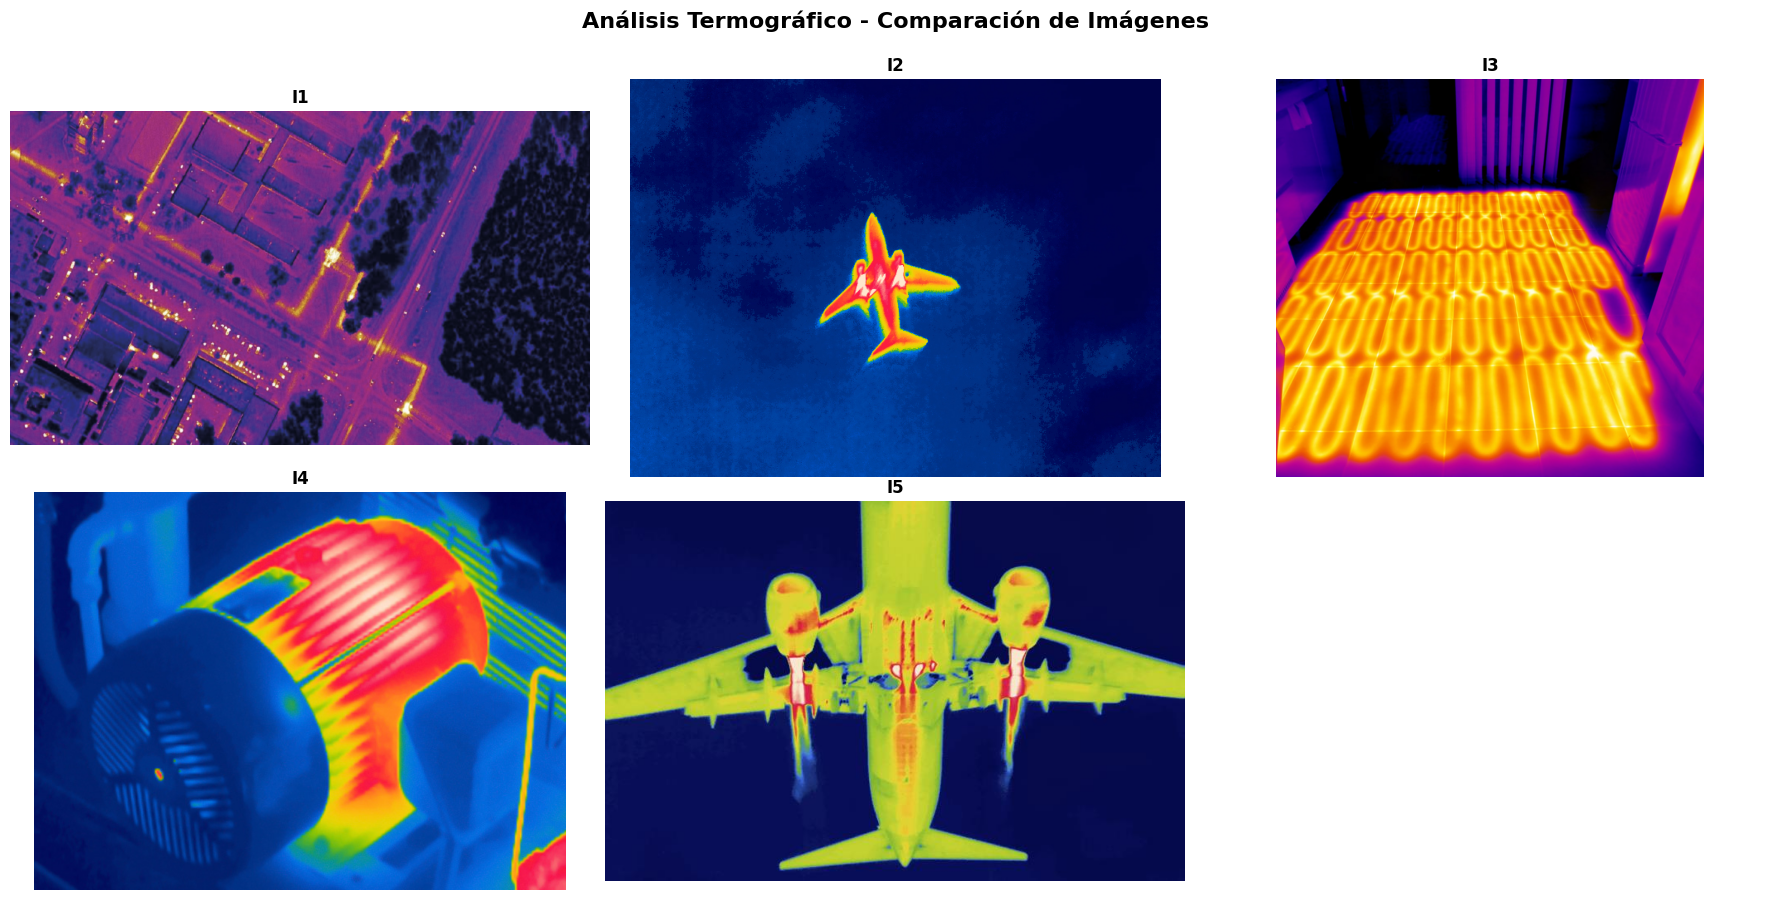

Archivos guardados:
 - ..\data\ImageOutput\grid_comparativo.png
 - ..\data\ImageOutput\grid_comparativo.svg


In [16]:
def create_and_save_grid(img_paths, cols=3, title='Análisis Termográfico - Comparación de Imágenes',
                         output_dir=OUTPUT_DIR, base_name='grid_comparativo', save_png=True, save_svg=True):
    # Cargar PILs
    imgs = []
    titles = []
    for p in img_paths:
        try:
            imgs.append(Image.open(p))
            titles.append(p.stem)
        except Exception:
            imgs.append(None)
            titles.append(f"{p.stem} (no disponible)")

    rows = int(np.ceil(len(imgs) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4.5*rows))
    axes = np.array(axes).reshape(-1)  # Garantizar vector

    for idx in range(rows*cols):
        ax = axes[idx]
        if idx < len(imgs) and imgs[idx] is not None:
            ax.imshow(imgs[idx])
            ax.set_title(titles[idx], fontsize=12, fontweight='bold')
            ax.axis('off')
        else:
            ax.axis('off')

    if title:
        plt.suptitle(title, fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    saved = save_figure(fig, base_name, output_dir=output_dir, save_png=save_png, save_svg=save_svg)
    plt.show()
    return saved

# Ejecutar y guardar un grid por defecto con todas las imágenes del directorio de entrada
print('Guardando grid comparativo en PNG y SVG...')
_grid_saved = create_and_save_grid(image_paths)
print('Archivos guardados:')
for p in _grid_saved:
    print(' -', p)

## 15. Hotspots, calibración y filtros de interés
En esta sección identificaremos automáticamente las zonas con mayor concentración de energía (hotspots), agregaremos una escala de color calibrable para interpretar valores, y permitiremos filtrar por regiones de interés (percentiles altos, ROI, contornos).

In [17]:
# Utilidades para hotspots, calibración, máscaras y anotaciones
from typing import List, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from PIL import Image
from pathlib import Path
from skimage.feature import peak_local_max
from skimage.morphology import opening, disk
import cv2

# Reusar OUTPUT_DIR si existe, y si no, crearlo por defecto
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = Path('..') / 'data' / 'ImageOutput'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def to_gray_array(img_pil: Image.Image) -> np.ndarray:
    """Convierte a escala de grises [0..255] uint8."""
    return np.array(img_pil.convert('L'))

def map_intensity_to_temperature(gray: np.ndarray, t_min: float, t_max: float) -> np.ndarray:
    """Mapea intensidad [0..255] a temperatura [t_min..t_max] mediante transformación lineal."""
    gray = gray.astype(np.float32)
    temp = t_min + (gray / 255.0) * (t_max - t_min)
    return temp

def build_mask_by_percentile(gray: np.ndarray, percentile: float, morph_open_radius: int = 0) -> np.ndarray:
    """Máscara booleana con píxeles por encima del percentil dado. Opcionalmente aplicar opening."""
    thr = np.percentile(gray, percentile)
    mask = gray >= thr
    if morph_open_radius and morph_open_radius > 0:
        selem = disk(max(1, morph_open_radius))
        mask = opening(mask.astype(np.uint8), selem) > 0
    return mask

def detect_hotspots(gray: np.ndarray, n: int = 5, neighborhood: int = 21, mask: Optional[np.ndarray] = None) -> List[Tuple[int,int,float]]:
    """Detecta hotspots mediante picos locales. Devuelve lista de (y, x, valor)."""
    if neighborhood < 3:
        neighborhood = 3
    min_dist = max(1, neighborhood // 2)
    coordinates = peak_local_max(gray, min_distance=min_dist, threshold_abs=None, labels=mask.astype(np.uint8) if mask is not None else None)
    # Ordenar por intensidad y tomar top n
    vals = [gray[y, x] for y, x in coordinates]
    order = np.argsort(vals)[::-1]
    selected = [(int(coordinates[i][0]), int(coordinates[i][1]), float(vals[i])) for i in order[:n]]
    return selected

def draw_hotspots(temp_map: np.ndarray, hotspots: List[Tuple[int,int,float]], base_img: Optional[np.ndarray] = None,
                   vmin: Optional[float] = None, vmax: Optional[float] = None, unit: str = '°C',
                   show_contours: bool = False, contour_sigma: float = 1.0) -> plt.Figure:
    """Dibuja mapa de temperatura con colorbar calibrada y anota hotspots. Opcional: contornos Canny."""
    fig, ax = plt.subplots(figsize=(8,6))
    if base_img is None:
        im = ax.imshow(temp_map, cmap='inferno', vmin=vmin, vmax=vmax)
    else:
        # Mostrar base en color y superponer temp con alpha
        ax.imshow(base_img)
        im = ax.imshow(temp_map, cmap='inferno', alpha=0.6, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(f'Temperatura [{unit}]', rotation=90)

    if show_contours:
        # Contornos con Canny sobre temp_map normalizado
        t_norm = (temp_map - np.nanmin(temp_map)) / (np.nanmax(temp_map) - np.nanmin(temp_map) + 1e-6)
        edges = cv2.Canny((t_norm*255).astype(np.uint8), 50, 150)
        ax.imshow(edges, cmap='gray', alpha=0.4)

    for i, (y, x, val) in enumerate(hotspots, start=1):
        ax.add_patch(Circle((x, y), radius=10, edgecolor='cyan', facecolor='none', linewidth=1.5))
        ax.text(x+12, y, f'#{i}', color='cyan', fontsize=10, weight='bold')
    ax.set_title('Hotspots y escala calibrada')
    ax.set_xlabel('X [px]'); ax.set_ylabel('Y [px]')
    ax.set_xlim(0, temp_map.shape[1]); ax.set_ylim(temp_map.shape[0], 0)
    fig.tight_layout()
    return fig

def save_figure(fig, base_name: str, output_dir=OUTPUT_DIR, save_png=True, save_svg=True):
    output_dir.mkdir(parents=True, exist_ok=True)
    saved = []
    if save_png:
        png_path = output_dir / f"{base_name}.png"
        fig.savefig(png_path, dpi=150, bbox_inches='tight')
        saved.append(png_path)
    if save_svg:
        svg_path = output_dir / f"{base_name}.svg"
        fig.savefig(svg_path, bbox_inches='tight')
        saved.append(svg_path)
    return saved

# --- NUEVO: estadísticas básicas y exportación CSV ---

def compute_basic_stats(gray: np.ndarray, mask: Optional[np.ndarray] = None) -> dict:
    """Calcula estadísticas sobre gray (o gray[mask])."""
    arr = gray if mask is None else gray[mask]
    arr = arr.astype(np.float32)
    if arr.size == 0:
        return {
            'count': 0, 'min': None, 'max': None, 'mean': None, 'std': None,
            'p50': None, 'p90': None, 'p95': None, 'p99': None,
            'masked_fraction': 0.0
        }
    stats = {
        'count': int(arr.size),
        'min': float(np.min(arr)),
        'max': float(np.max(arr)),
        'mean': float(np.mean(arr)),
        'std': float(np.std(arr)),
        'p50': float(np.percentile(arr, 50)),
        'p90': float(np.percentile(arr, 90)),
        'p95': float(np.percentile(arr, 95)),
        'p99': float(np.percentile(arr, 99)),
        'masked_fraction': float(arr.size / gray.size) if mask is not None else 1.0
    }
    return stats

def hotspots_to_records(hotspots: List[Tuple[int,int,float]], tmap: np.ndarray, filename: str,
                        unit: str, roi_offset_xy: Tuple[int,int] = (0,0)) -> List[dict]:
    """Convierte hotspots a lista de dicts incluyendo temperatura y coords absolutas."""
    off_x, off_y = roi_offset_xy
    records = []
    for idx, (y, x, val) in enumerate(hotspots, start=1):
        temp = float(tmap[y, x]) if 0 <= y < tmap.shape[0] and 0 <= x < tmap.shape[1] else None
        records.append({
            'file': filename,
            'idx': idx,
            'x_roi': int(x), 'y_roi': int(y),
            'x': int(x + off_x), 'y': int(y + off_y),
            'intensity_0_255': float(val),
            'temperature': temp,
            'unit': unit
        })
    return records

def save_hotspots_csv(records: List[dict], base_name: str, output_dir=OUTPUT_DIR) -> Path:
    import pandas as pd
    df = pd.DataFrame.from_records(records)
    csv_path = output_dir / f"{base_name}.csv"
    df.to_csv(csv_path, index=False, encoding='utf-8')
    return csv_path

Output(layout=Layout(border_bottom='1px solid #ddd', border_left='1px solid #ddd', border_right='1px solid #dd…

Output(layout=Layout(border_bottom='1px solid #eee', border_left='1px solid #eee', border_right='1px solid #ee…

Output()

Las salidas se guardarán en: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P07_Termografia\data\ImageOutput 


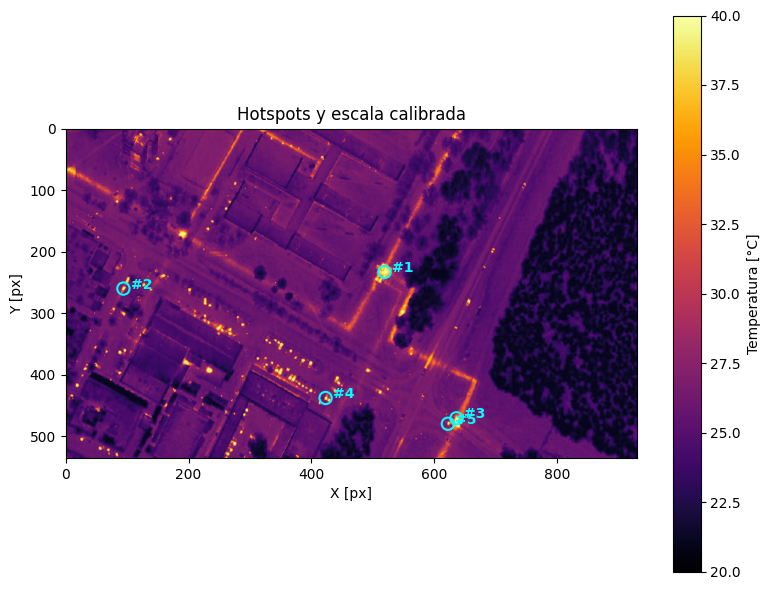

In [18]:
# Widgets y flujo interactivo para hotspots/calibración/ROI/contornos
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# Reutilizar image_paths si existe, si no, crearlo como en sección anterior
try:
    image_paths
except NameError:
    INPUT_DIR = Path('..') / '..' / '..' / 'files' / 'p7'
    VALID_EXTS = {'.png', '.jpg', '.jpeg', '.tif', '.tiff'}
    image_paths = sorted([p for p in INPUT_DIR.iterdir() if p.suffix.lower() in VALID_EXTS])

image_names = [p.name for p in image_paths]

# Selección de imagen y canal (para base de visualización)
w_image = widgets.Dropdown(options=image_names, description='Imagen:')
w_show_rgb = widgets.Dropdown(options=['Gris (L)','RGB superpuesto'], value='Gris (L)', description='Mostrar:')
w_unit = widgets.Text(value='°C', description='Unidades:')

# Calibración de escala: mapeo 0..255 -> [Tmin..Tmax]
w_tmin = widgets.FloatText(value=20.0, description='T min')
w_tmax = widgets.FloatText(value=40.0, description='T max')

# Hotspots
w_n = widgets.IntSlider(value=5, min=1, max=20, step=1, description='N hotspots')
w_neigh = widgets.IntSlider(value=21, min=5, max=101, step=2, description='Vecindario')

# Máscara por percentil y morfología
w_use_mask = widgets.Checkbox(value=True, description='Limitar por percentil')
w_percent = widgets.FloatSlider(value=95.0, min=50.0, max=99.9, step=0.1, description='Percentil')
w_open_r = widgets.IntSlider(value=2, min=0, max=10, step=1, description='Abertura r')

# Contornos
w_contours = widgets.Checkbox(value=False, description='Mostrar contornos')
w_canny_sigma = widgets.FloatSlider(value=1.0, min=0.5, max=3.0, step=0.1, description='Canny σ')

# ROI opcional (para restringir procesamiento)
w_use_roi = widgets.Checkbox(value=False, description='Usar ROI')
w_left = widgets.IntText(value=50, description='left')
w_upper = widgets.IntText(value=50, description='upper')
w_right = widgets.IntText(value=250, description='right')
w_lower = widgets.IntText(value=250, description='lower')

# Herramienta para leer intensidad en (x,y)
w_x = widgets.IntText(value=100, description='x')
w_y = widgets.IntText(value=100, description='y')
w_read = widgets.Button(description='Leer intensidad', icon='crosshairs')
w_read_out = widgets.Output()

# Ejecución y guardado
w_run_hot = widgets.Button(description='Detectar hotspots', button_style='primary', icon='fire')
w_save_fig = widgets.Button(description='Guardar figura', button_style='success', icon='save')
w_save_csv = widgets.Button(description='Guardar CSV', icon='table')
w_status = widgets.Output(layout={'border': '1px solid #ddd'})
w_stats = widgets.Output(layout={'border': '1px solid #eee'})
w_out = widgets.Output()

# Estado simple
_LAST_FIG = None
_LAST_NAME = None
_LAST_GRAY = None
_LAST_TMAP = None
_LAST_HS = None
_LAST_MASK = None
_LAST_ROI_OFFSET = (0, 0)


def _get_current_image() -> Optional[Path]:
    if not image_paths or not w_image.options:
        return None
    return next((p for p in image_paths if p.name == w_image.value), None)

def _apply_roi(gray: np.ndarray) -> np.ndarray:
    if not w_use_roi.value:
        return gray
    l,u,r,b = w_left.value, w_upper.value, w_right.value, w_lower.value
    l = max(0, l); u = max(0, u)
    r = min(gray.shape[1], r); b = min(gray.shape[0], b)
    if r <= l or b <= u:
        return gray
    sub = gray[u:b, l:r].copy()
    return sub

def _read_intensity_at(gray: np.ndarray, x: int, y: int) -> Optional[int]:
    if 0 <= y < gray.shape[0] and 0 <= x < gray.shape[1]:
        return int(gray[y, x])
    return None

@w_read.on_click
def _on_read_clicked(btn):
    with w_read_out:
        clear_output(wait=True)
        img_path = _get_current_image()
        if img_path is None:
            print('No hay imagen disponible.')
            return
        gray_full = to_gray_array(Image.open(img_path))
        gray = _apply_roi(gray_full)
        val = _read_intensity_at(gray, w_x.value, w_y.value)
        if val is None:
            print('Coordenadas fuera de rango para el ROI/imagen actual.')
        else:
            print(f'Intensidad en (x={w_x.value}, y={w_y.value}) = {val}')

@w_run_hot.on_click
def _on_run_hot(btn):
    global _LAST_FIG, _LAST_NAME, _LAST_GRAY, _LAST_TMAP, _LAST_HS, _LAST_MASK, _LAST_ROI_OFFSET
    w_out.clear_output(); w_status.clear_output(); w_stats.clear_output()
    with w_status:
        img_path = _get_current_image()
        if img_path is None:
            print('Selecciona una imagen válida.')
            return
        # Cargar y preparar
        pil = Image.open(img_path)
        gray_full = to_gray_array(pil)
        gray = _apply_roi(gray_full)
        _LAST_GRAY = gray.copy()
        # ROI offset
        if w_use_roi.value:
            l,u = int(w_left.value), int(w_upper.value)
            _LAST_ROI_OFFSET = (max(0, l), max(0, u))
        else:
            _LAST_ROI_OFFSET = (0, 0)
        # Máscara por percentil
        mask = None
        if w_use_mask.value:
            mask = build_mask_by_percentile(gray, w_percent.value, morph_open_radius=w_open_r.value)
        _LAST_MASK = mask
        # Detectar hotspots
        hs = detect_hotspots(gray, n=w_n.value, neighborhood=w_neigh.value, mask=mask)
        _LAST_HS = hs
        # Mapa de temperatura calibrado
        tmap = map_intensity_to_temperature(gray, w_tmin.value, w_tmax.value)
        _LAST_TMAP = tmap
        # Base visual
        base = None
        if w_show_rgb.value == 'RGB superpuesto':
            base = np.array(pil)
            if w_use_roi.value:
                l,u,r,b = w_left.value, w_upper.value, w_right.value, w_lower.value
                l = max(0, l); u = max(0, u)
                r = min(base.shape[1], r); b = min(base.shape[0], b)
                base = base[u:b, l:r]
        # Figura
        fig = draw_hotspots(tmap, hs, base_img=base, vmin=w_tmin.value, vmax=w_tmax.value, unit=w_unit.value,
                            show_contours=w_contours.value, contour_sigma=w_canny_sigma.value)
        _LAST_FIG = fig
        _LAST_NAME = img_path.stem
        with w_out:
            display(fig)
        print(f'Detectados {len(hs)} hotspots. Top-1 intensidad (0..255): {hs[0][2]:.1f}' if hs else 'Sin hotspots detectados.')

    # Tablero de estadísticas
    with w_stats:
        # Estadísticas globales (sobre ROI o imagen completa si no hay ROI)
        stats_all = compute_basic_stats(_LAST_GRAY, mask=None)
        print('Estadísticas (ROI/imagen actual):')
        for k in ['count','min','max','mean','std','p50','p90','p95','p99']:
            print(f'  {k}: {stats_all[k]}')
        # Si hay máscara, estadísticas sobre la máscara
        if _LAST_MASK is not None:
            stats_m = compute_basic_stats(_LAST_GRAY, mask=_LAST_MASK)
            print('\nEstadísticas en máscara (percentil alto):')
            for k in ['count','min','max','mean','std','p50','p90','p95','p99']:
                print(f'  {k}: {stats_m[k]}')
            frac = float(np.sum(_LAST_MASK)) / _LAST_GRAY.size if _LAST_GRAY.size else 0.0
            print(f'  masked_fraction: {frac:.4f}')
        # Vista rápida de hotspots
        if _LAST_HS:
            recs = hotspots_to_records(_LAST_HS, _LAST_TMAP, _LAST_NAME, unit=w_unit.value, roi_offset_xy=_LAST_ROI_OFFSET)
            df = pd.DataFrame.from_records(recs)
            print('\nTop hotspots:')
            display(df.head(len(_LAST_HS)))

@w_save_fig.on_click
def _on_save_fig(btn):
    with w_status:
        clear_output(wait=True)
        if _LAST_FIG is None or _LAST_NAME is None:
            print('No hay figura para guardar. Ejecuta "Detectar hotspots" primero.')
            return
        base_name = f"hotspots_{_LAST_NAME}_N{w_n.value}_P{int(w_percent.value)}" if w_use_mask.value else f"hotspots_{_LAST_NAME}_N{w_n.value}"
        saved = save_figure(_LAST_FIG, base_name, output_dir=OUTPUT_DIR, save_png=True, save_svg=True)
        print('Guardado:')
        for p in saved:
            print(' -', p)

@w_save_csv.on_click
def _on_save_csv(btn):
    with w_status:
        clear_output(wait=True)
        if _LAST_HS is None or _LAST_TMAP is None or _LAST_NAME is None:
            print('No hay resultados para CSV. Ejecuta "Detectar hotspots" primero.')
            return
        recs = hotspots_to_records(_LAST_HS, _LAST_TMAP, _LAST_NAME, unit=w_unit.value, roi_offset_xy=_LAST_ROI_OFFSET)
        base_name = f"hotspots_{_LAST_NAME}_N{w_n.value}_P{int(w_percent.value)}" if w_use_mask.value else f"hotspots_{_LAST_NAME}_N{w_n.value}"
        csv_path = save_hotspots_csv(recs, base_name, output_dir=OUTPUT_DIR)
        print('CSV guardado:')
        print(' -', csv_path)

# Layout UI
col_left = widgets.VBox([
    widgets.HTML('<b>Entrada</b>'),
    w_image, w_show_rgb, w_unit,
    widgets.HTML('<b>Calibración</b>'),
    widgets.HBox([w_tmin, w_tmax]),
    widgets.HTML('<b>Hotspots</b>'),
    widgets.HBox([w_n, w_neigh]),
])
col_mid = widgets.VBox([
    widgets.HTML('<b>Máscara (percentil)</b>'),
    w_use_mask, w_percent, w_open_r,
    widgets.HTML('<b>Contornos</b>'),
    w_contours, w_canny_sigma,
])
col_right = widgets.VBox([
    widgets.HTML('<b>ROI (opcional)</b>'),
    w_use_roi, widgets.HBox([w_left, w_upper]), widgets.HBox([w_right, w_lower]),
    widgets.HTML('<b>Muestreo de intensidad</b>'),
    widgets.HBox([w_x, w_y]), w_read, w_read_out,
    widgets.HBox([w_run_hot, w_save_fig, w_save_csv])
])
ui_hot = widgets.HBox([col_left, col_mid, col_right])
display(ui_hot, w_status, w_stats, w_out)
print(f"Las salidas se guardarán en: {OUTPUT_DIR.resolve()} ")